# Data

[*********************100%%**********************]  1 of 1 completed

Epoch 1/50


39/39 [==============================] - 2s 32ms/step - loss: 0.0029 - val_loss: 4.4693e-04
Epoch 2/50
39/39 [==============================] - 1s 26ms/step - loss: 1.4712e-04 - val_loss: 4.4450e-04
Epoch 3/50
39/39 [==============================] - 1s 25ms/step - loss: 1.1145e-04 - val_loss: 4.2826e-04
Epoch 4/50
39/39 [==============================] - 1s 25ms/step - loss: 1.1045e-04 - val_loss: 4.2251e-04
Epoch 5/50
39/39 [==============================] - 1s 25ms/step - loss: 9.3456e-05 - val_loss: 4.6262e-04
Epoch 6/50
39/39 [==============================] - 1s 25ms/step - loss: 9.8062e-05 - val_loss: 5.0822e-04
Epoch 7/50
39/39 [==============================] - 1s 25ms/step - loss: 1.0053e-04 - val_loss: 4.4498e-04
Epoch 8/50
39/39 [==============================] - 1s 25ms/step - loss: 8.8002e-05 - val_loss: 3.8684e-04
Epoch 9/50
39/39 [==============================] - 1s 25ms/step - loss: 8.4490e-05 - val_loss: 3.8661e-04
Epoch 10/50
39/39 [==============================] -

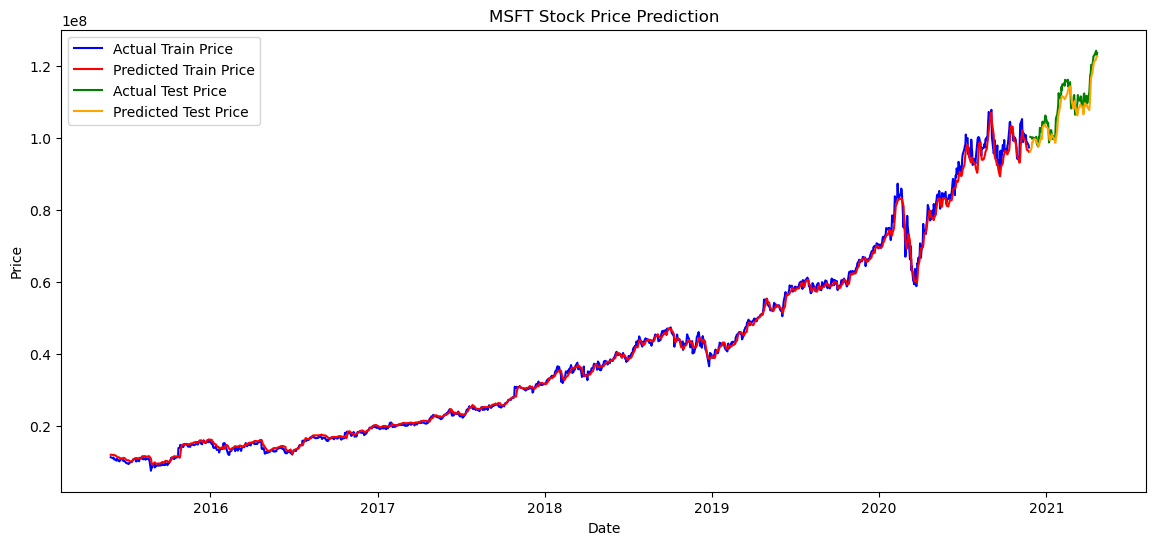

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Download MSFT stock data using yfinance library
import yfinance as yf

# Download MSFT stock data
msft_data = yf.download('MSFT', start='2015-01-01', end='2022-04-14')

msft_data['MSFT_SMA_50'] = msft_data['Close'].rolling(window=50).mean()
msft_data['MSFT_Log_Return'] = np.log(msft_data['Close'] / msft_data['Close'].shift(1))
def calculate_rsi(data, window):
    diff = data['Close'].diff()
    up_changes = diff.where(diff > 0, 0)
    down_changes = -diff.where(diff < 0, 0)

    avg_gain = up_changes.ewm(com=window - 1, adjust=False).mean()
    avg_loss = down_changes.ewm(com=window - 1, adjust=False).mean()

    rs = abs(avg_gain / avg_loss)
    rsi = 100 - (100 / (1 + rs))
    return rsi

msft_data['MSFT_RSI_14'] = calculate_rsi(msft_data, 14) 

# Define the number of timesteps
timesteps = 100

# Prepare data
def prepare_data(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps - 1):
        X.append(data[i:(i + timesteps)])
        y.append(data[i + timesteps, 0])  # Assuming the 'Close' price is the first column
    return np.array(X), np.array(y)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(msft_data[['Open', 'High', 'Low', 'Close', 'Volume']].values)

# Prepare training data
X, y = prepare_data(scaled_data, timesteps)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(timesteps, X.shape[2])))
model.add(LSTM(units=32))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(np.concatenate((X_train[:, -1, 1:], train_predictions), axis=1))[:, -1]
test_predictions = scaler.inverse_transform(np.concatenate((X_test[:, -1, 1:], test_predictions), axis=1))[:, -1]
y_train = scaler.inverse_transform(np.concatenate((X_train[:, -1, 1:], y_train.reshape(-1, 1)), axis=1))[:, -1]
y_test = scaler.inverse_transform(np.concatenate((X_test[:, -1, 1:], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(msft_data.index[timesteps:train_size+timesteps], y_train, color='blue', label='Actual Train Price')
plt.plot(msft_data.index[timesteps:train_size+timesteps], train_predictions, color='red', label='Predicted Train Price')
plt.plot(msft_data.index[train_size+timesteps+1:train_size+2*timesteps+1], y_test[:timesteps], color='green', label='Actual Test Price')
plt.plot(msft_data.index[train_size+timesteps+1:train_size+2*timesteps+1], test_predictions[:timesteps], color='orange', label='Predicted Test Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
